## 1日の中で時間ごとの歩数の遷移をモデル化する

### ランダムで9人の10日間の歩数を時間ごとに描画

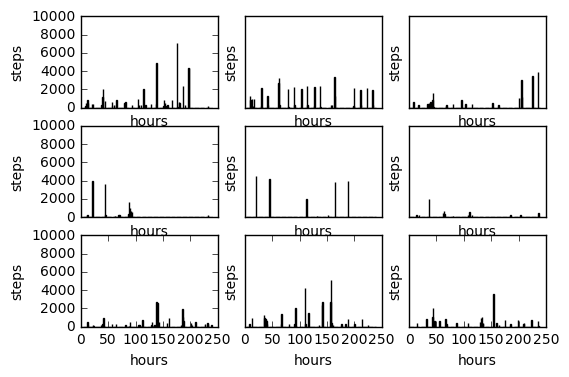

In [1]:
%matplotlib inline
import random
import numpy
import matplotlib.pylab as plt

f = open('datasets.npz', 'rb')
dataset = numpy.load(f)
X = dataset['all']

f, axes = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        datasets = X[random.randint(0, X.shape[0] - 1)]
        # print 'dataset: ', dataset
        axes[i][j].bar(xrange(240), datasets)
        axes[i][j].set_xlabel('hours')
        axes[i][j].set_ylabel('steps')
        axes[i][j].set_ylim(0, 10000)
        if i != 2:
            axes[i][j].set_xticks([])
        if j != 0:
            axes[i][j].set_yticks([])
plt.show()

### 10日の中で1時間ごとの歩数のヒストグラムを作成

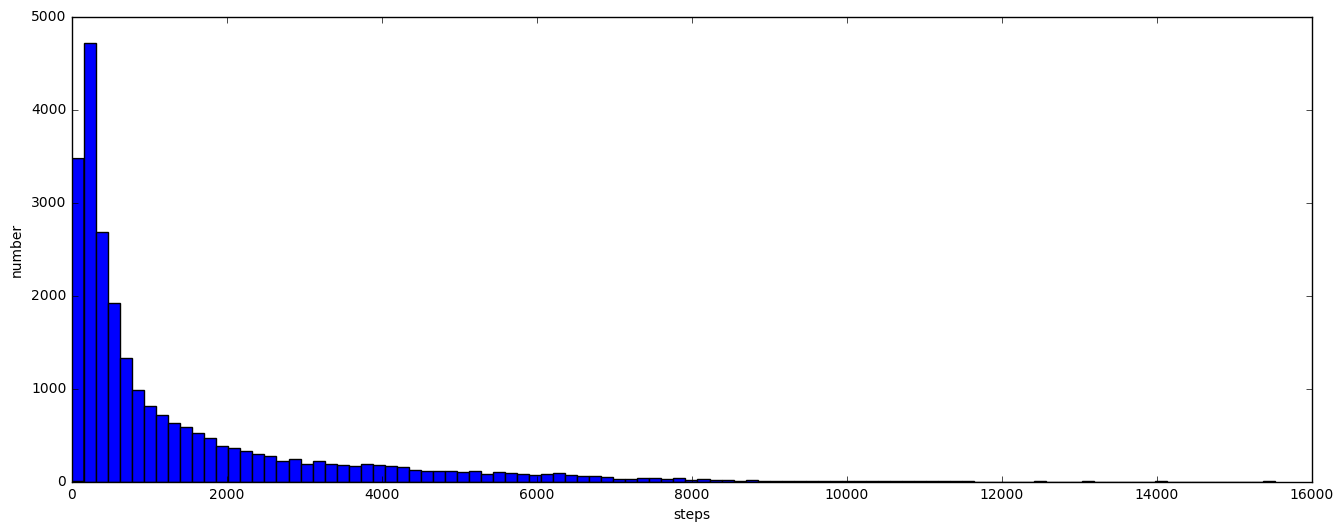

In [2]:
plt.figure(figsize=(16,6))
plt.hist(X[X != 0], bins=100)
plt.ylabel('number')
plt.xlabel('steps')
plt.show()

### 対照群A：現状のレコードで距離が近い順

In [3]:
import numpy
import logging
reload(logging)
logging.basicConfig(level=logging.DEBUG)

def pick_conditional_data(target, src, num=5):
    """
    8000歩以上、かつ、距離が近いものからnum分だけ返す
    """
    dim = target.shape[0]
    ## 各ベクタごとにsumを計算
    sums = numpy.apply_along_axis(lambda x: x.sum(), 1, src)
    ## 8000歩を超えるデータのみ抽出
    sum_cond_cleared = src[sums > 8000]
    ## 条件を満たしたベクタの中で、各ベクタごとに距離を計算
    distances = numpy.apply_along_axis(lambda x: abs(x[:dim].sum() - target.sum()), 1, sum_cond_cleared)
    ## 条件を満たした中で、上位num位を返す
    return sum_cond_cleared[numpy.argsort(distances)[:num]], sum_cond_cleared.shape[0]

### pick_conditional_dataの計算テスト

In [4]:
### 6日目のデータ
day6 = X[:, 5*24:6*24]
alldays = numpy.vstack([X[:, i*24:(i+1)*24] for i in range(10)])
print "picking one from day6 ..."

for i in range(5):
    target = sorted(day6, key=lambda k: random.random())[0]
    print "picked: ", target.shape, target.sum(), ["%d" % x  for x in target]
    choiced, _ = pick_conditional_data(target, alldays)
    print numpy.apply_along_axis(lambda x: x.sum(), 1, choiced)

picking one from day6 ...
picked:  (24,) 1897.0 ['0', '0', '0', '0', '0', '0', '0', '0', '482', '491', '0', '0', '0', '0', '0', '412', '273', '239', '0', '0', '0', '0', '0', '0']
[ 8002.  8005.  8005.  8006.  8007.]
picked:  (24,) 6012.0 ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '689', '723', '1547', '0', '0', '581', '0', '0', '1928', '544', '0', '0', '0', '0']
[ 8002.  8005.  8005.  8006.  8007.]
picked:  (24,) 600.0 ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '230', '0', '0', '0', '370', '0', '0', '0', '0', '0', '0', '0', '0', '0']
[ 8002.  8005.  8005.  8006.  8007.]
picked:  (24,) 12587.0 ['0', '0', '0', '0', '0', '0', '0', '0', '3737', '72', '0', '4378', '347', '4052', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
[ 12587.  12589.  12575.  12602.  12615.]
picked:  (24,) 848.0 ['0', '0', '0', '0', '0', '0', '0', '0', '175', '0', '0', '412', '0', '0', '0', '0', '0', '261', '0', '0', '0', '0', '0', '0']
[ 8002.  8005.  8005.  8006.  8007.]


### 4時間ずつの検索結果とその距離をだす

(0, 24)

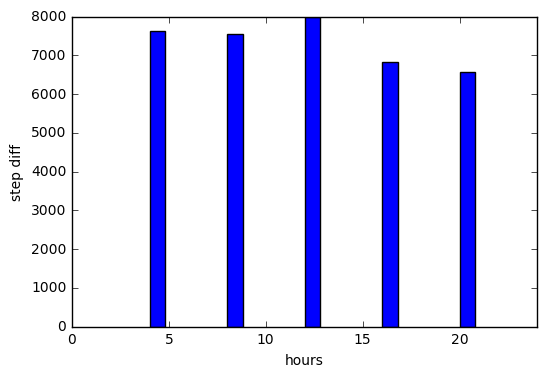

In [5]:
import numpy
import matplotlib.pylab as plt

day6 = X[:, 5*24:6*24]
alldays = numpy.vstack([X[:, i*24:(i+1)*24] for i in range(10)])

means_per_hour = []
total_num = []

for limit in numpy.arange(4, 24, 4):
    means = []
    for i in range(X.shape[0] / 10):
        full_target = sorted(day6, key=lambda k: random.random())[0]
        target = full_target[:limit]
        choiced, total_num = pick_conditional_data(target, alldays)
        means.append(numpy.apply_along_axis(lambda x: abs(x.sum() - full_target.sum()), 1, choiced).mean())
    means_per_hour.append(numpy.average(means))

plt.bar(numpy.arange(4, 24, 4), means_per_hour)
plt.xlabel("hours")
plt.ylabel("step diff")
plt.xlim(0, 24)

### 対照群B：クラスタリングしてから検索

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clusters = 10

print "Exec Ward Agglomerative Clustering ..."

alldays = numpy.vstack([X[:, i*24:(i+1)*24] for i in range(10)])

for type in ["ward", "complete", "average"]:
    print "goinng to", type, "clustering ..."
    ward = AgglomerativeClustering(linkage=type, n_clusters=clusters)
    clustered = ward.fit_predict(alldays)
    print "clustered: ", clustered.shape, clustered.dtype

    for i in range(clusters):
        print "[%d] %d" % (i, numpy.count_nonzero(clustered == i))

In [6]:
from sklearn.cluster import KMeans

clusters = 10

print "Exec KMeans Clustering ..."

alldays = numpy.vstack([X[:, i*24:(i+1)*24] for i in range(10)])

kmeans = KMeans(n_clusters=clusters, random_state=0)
clustered = kmeans.fit_predict(alldays)
print "clustered: ", clustered.shape, clustered.dtype, "max: ", clustered.max(), "min: ", clustered.min()

for i in range(clusters):
    print "[%d] %d" % (i, numpy.count_nonzero(clustered == i))

Exec KMeans Clustering ...
clustered:  (7040,) int32 max:  9 min:  0
[0] 4890
[1] 234
[2] 109
[3] 273
[4] 234
[5] 190
[6] 252
[7] 425
[8] 152
[9] 281


In [ ]:
import numpy
from sklearn.cluster import SpectralClustering

clusters = 10

print "Exec Spectral Clustering ..."

alldays = numpy.vstack([X[:, i*24:(i+1)*24] for i in range(10)])

spectral = SpectralClustering(n_clusters=clusters, eigen_solver='arpack', affinity="nearest_neighbors")
clustered = spectral.fit_predict(alldays)
print "clustered: ", clustered.shape, clustered.dtype, "max: ", clustered.max(), "min: ", clustered.min()

for i in range(clusters):
    print "[%d] %d" % (i, numpy.count_nonzero(clustered == i))

In [19]:
import numpy
import collections
import matplotlib.pylab as plt

day6 = X[:, 5*24:6*24]
alldays = numpy.vstack([X[:, i*24:(i+1)*24] for i in range(10)])

a_means_per_hour = []
b_means_per_hour = []
a_candidates_per_hour = []
b_candidates_per_hour = []
majorities = []

for limit in numpy.arange(4, 24, 4):
    a_means = []
    a_candidates = []
    b_means = []
    b_candidates = []

    for i in range(X.shape[0] / 10):
        idx = random.randint(0, day6.shape[0] - 1)
        full_target = day6[idx]
        target = full_target[:limit]

        ## A pattern
        choiced, total_num = pick_conditional_data(target, alldays)
        a_means.append(numpy.apply_along_axis(lambda x: abs(x.sum() - full_target.sum()), 1, choiced).mean())
        a_candidates.append(total_num)

        ## B pattern
        history = [X[idx, i*24:(i+1)*24] for i in range(5)]
        predicted = kmeans.predict(history)
        cluster_num = predicted[numpy.argmax(predicted)]
        uniques, counts = numpy.unique(predicted, return_counts=True)
        cluster_num_map = dict(zip(uniques, counts))
        majorities.append(float(cluster_num_map[cluster_num])/float(predicted.shape[0]))
        src = alldays[clustered == cluster_num]
        choiced, total_num = pick_conditional_data(target, src)
        b_means.append(numpy.apply_along_axis(lambda x: abs(x.sum() - full_target.sum()), 1, choiced).mean())
        b_candidates.append(total_num)
    
    a_means_per_hour.append(numpy.average(a_means))
    b_means_per_hour.append(numpy.average(b_means))
    a_candidates_per_hour.append(numpy.average(a_candidates))
    b_candidates_per_hour.append(numpy.average(b_candidates))

print "baseline means: ", a_means_per_hour
print "\tcandidates: ", a_candidates_per_hour
print "proposed method means: ", b_means_per_hour
print "\tcandidates: ", b_candidates_per_hour
print "majorities: ", sum(majorities) / float(len(majorities))

 baseline means:  [8408.9219, 7350.9702, 8140.1055, 7281.2427, 6127.0747]
	candidates:  [1339.0, 1339.0, 1339.0, 1339.0, 1339.0]
proposed method means:  [8725.3525, 8614.1338, 7833.8696, 6931.5928, 5587.5859]
	candidates:  [138.64285714285714, 148.08571428571429, 140.18571428571428, 146.91428571428571, 141.05714285714285]
majorities:  0.555428571429


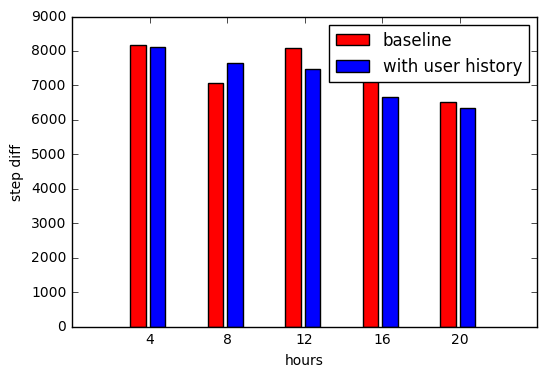

In [12]:
plt.bar(numpy.arange(4, 24, 4) - 1.0, a_means_per_hour, color="red", label="baseline")
plt.bar(numpy.arange(4, 24, 4), b_means_per_hour, label="with user history")
plt.xlabel("hours")
plt.ylabel("step diff")
plt.xlim(0, 24)
plt.xticks(numpy.arange(4,24,4))
plt.legend()

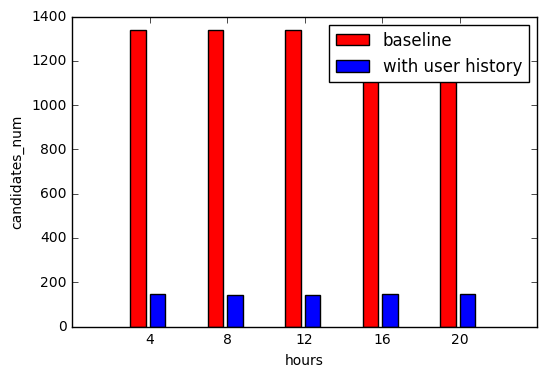

In [14]:
plt.bar(numpy.arange(4, 24, 4) - 1.0, a_candidates_per_hour, color="red", label="baseline")
plt.bar(numpy.arange(4, 24, 4), b_candidates_per_hour, label="with user history")
plt.xlabel("hours")
plt.ylabel("candidates_num")
plt.xlim(0, 24)
plt.xticks(numpy.arange(4,24,4))
plt.legend()